## Settings

In [1]:
!pip install netCDF4 h5py tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xarray
#!apt-get -qq install libproj-dev libgeos-dev
#!pip install cartopy

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import keras

## need

In [9]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [10]:
import keras_tuner
import tensorflow as tf

## Data

In [39]:
# Load NetCDF file
file_path = '/content/drive/MyDrive/organized_data_final.nc'
data = xr.open_dataset(file_path)

co2 = data['co2_data']
temp = data['temp_data']
year_month = data['year_month']

In [40]:
# Reshape XCO2 data for LSTM input
co2_reshaped = co2.values.reshape((86, -1))

# Normalize data
scaler = MinMaxScaler()
co2_normalized = scaler.fit_transform(co2_reshaped)

#input sequences
sequence_length = 12


In [41]:
X, y = [], []
for i in range(86 - sequence_length):
    X.append(co2_normalized[i:i+sequence_length, :])
    y.append(co2_normalized[i+sequence_length, :])

X, y = np.array(X), np.array(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59, 12, 64800)
(15, 12, 64800)
(59, 64800)
(15, 64800)


## Actual vs prediction model - CO2 LSTM model

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[2]))

model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50
2/2 - 4s - loss: 0.2483 - val_loss: 0.3322 - 4s/epoch - 2s/step
Epoch 2/50
2/2 - 0s - loss: 0.2387 - val_loss: 0.3162 - 500ms/epoch - 250ms/step
Epoch 3/50
2/2 - 0s - loss: 0.2249 - val_loss: 0.2979 - 470ms/epoch - 235ms/step
Epoch 4/50
2/2 - 0s - loss: 0.2087 - val_loss: 0.2791 - 461ms/epoch - 231ms/step
Epoch 5/50
2/2 - 0s - loss: 0.1930 - val_loss: 0.2602 - 444ms/epoch - 222ms/step
Epoch 6/50
2/2 - 0s - loss: 0.1775 - val_loss: 0.2419 - 440ms/epoch - 220ms/step
Epoch 7/50
2/2 - 0s - loss: 0.1622 - val_loss: 0.2245 - 444ms/epoch - 222ms/step
Epoch 8/50
2/2 - 0s - loss: 0.1483 - val_loss: 0.2081 - 444ms/epoch - 222ms/step
Epoch 9/50
2/2 - 0s - loss: 0.1349 - val_loss: 0.1928 - 443ms/epoch - 222ms/step
Epoch 10/50
2/2 - 0s - loss: 0.1227 - val_loss: 0.1787 - 452ms/epoch - 226ms/step
Epoch 11/50
2/2 - 0s - loss: 0.1117 - val_loss: 0.1656 - 459ms/epoch - 230ms/step
Epoch 12/50
2/2 - 0s - loss: 0.1020 - val_loss: 0.1538 - 450ms/epoch - 225ms/step
Epoch 13/50
2/2 - 0s - loss: 0.

In [ ]:
#predictions
y_pred = model.predict(X_test)

#Inverse transform the normalized predictions and actual values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)


1/1 [==============================] - 0s 163ms/step


R^2 Score: -0.070570681906154


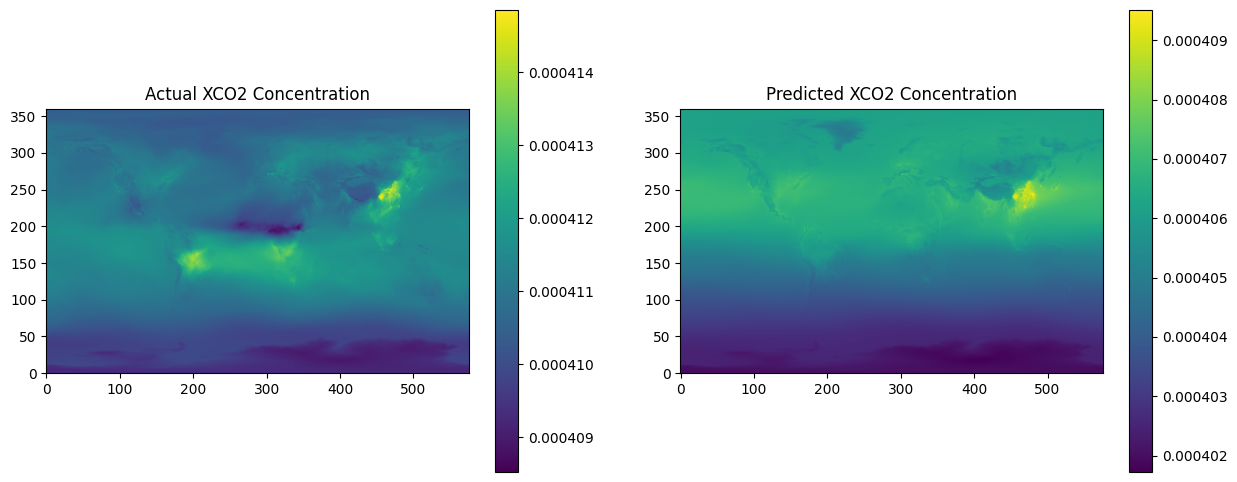

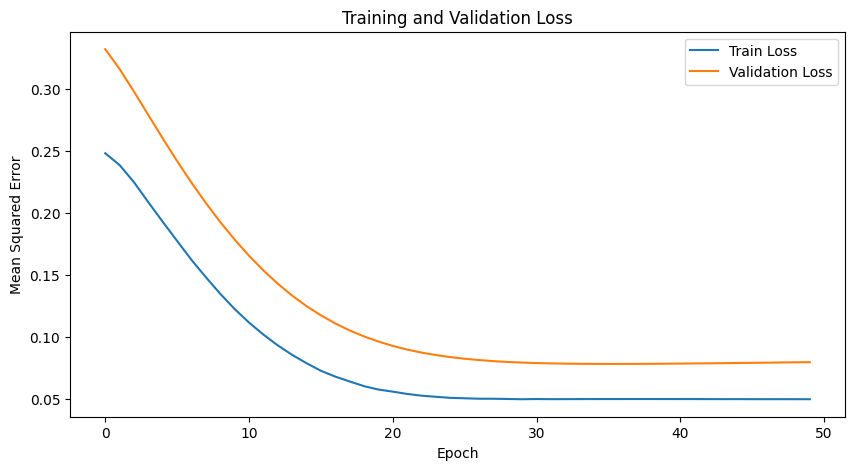

In [ ]:
# Evaluate R^2 score
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f'R^2 Score: {r2}')

# Plotting actual vs predicted maps
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_test_inverse[0, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Actual XCO2 Concentration')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_inverse[0, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Predicted XCO2 Concentration')
plt.colorbar()

plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

##Actual vs prediction model - CO2 LSTM model with extra LSTM, dense layer, increased epochs.

In [ ]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(200, return_sequences=False))
#model.add(LSTM(100))
model.add(Dense(X_train.shape[2]))  # Output layer has the same number of features as input


In [ ]:
custom_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='mse')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
4/4 - 4s - loss: 0.4066 - val_loss: 0.3203 - 4s/epoch - 958ms/step
Epoch 2/100
4/4 - 0s - loss: 0.3855 - val_loss: 0.2956 - 317ms/epoch - 79ms/step
Epoch 3/100
4/4 - 0s - loss: 0.3540 - val_loss: 0.2650 - 328ms/epoch - 82ms/step
Epoch 4/100
4/4 - 0s - loss: 0.3153 - val_loss: 0.2299 - 323ms/epoch - 81ms/step
Epoch 5/100
4/4 - 0s - loss: 0.2732 - val_loss: 0.1927 - 315ms/epoch - 79ms/step
Epoch 6/100
4/4 - 0s - loss: 0.2264 - val_loss: 0.1559 - 316ms/epoch - 79ms/step
Epoch 7/100
4/4 - 0s - loss: 0.1823 - val_loss: 0.1228 - 317ms/epoch - 79ms/step
Epoch 8/100
4/4 - 0s - loss: 0.1389 - val_loss: 0.0961 - 327ms/epoch - 82ms/step
Epoch 9/100
4/4 - 0s - loss: 0.1043 - val_loss: 0.0775 - 327ms/epoch - 82ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0780 - val_loss: 0.0677 - 323ms/epoch - 81ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0609 - val_loss: 0.0658 - 321ms/epoch - 80ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0526 - val_loss: 0.0689 - 326ms/epoch - 82ms/step
Epoch 13/100
4/4 - 0s - los

## Test

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the normalized predictions and actual values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

1/1 [==============================] - 1s 636ms/step


In [ ]:
X_test.shape

(15, 12, 64800)

In [ ]:
y_pred.shape

(15, 64800)

In [ ]:
y_test.shape

(15, 64800)

In [ ]:
r2 = r2_score(y_pred, y_test)

In [ ]:
r2

0.8385738794359748

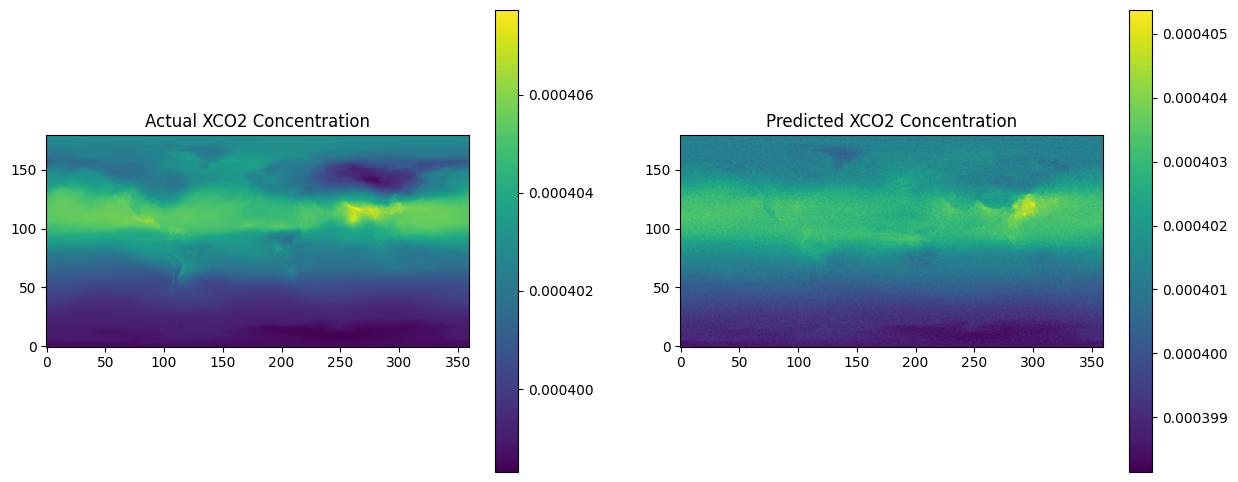

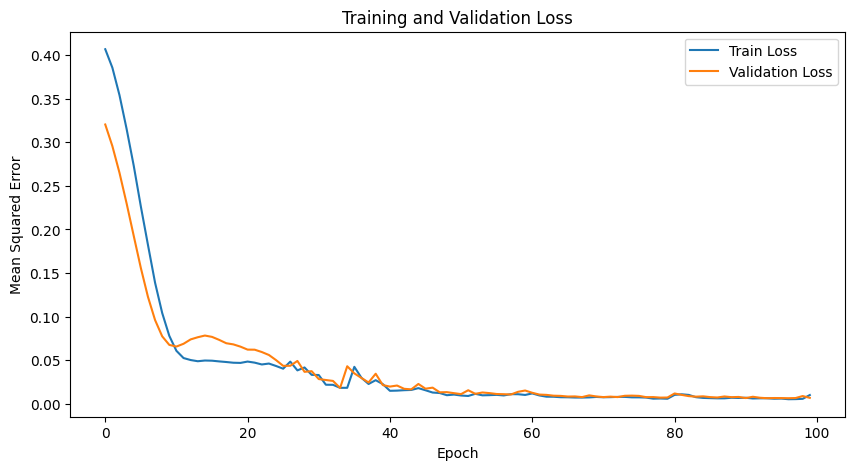

In [ ]:
# Plotting actual vs predicted maps
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_test_inverse[14, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Actual XCO2 Concentration')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_inverse[14, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Predicted XCO2 Concentration')
plt.colorbar()

plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

#model.save('/content/drive/MyDrive/GHG_Project/models/CO2_lstm_extra_layer_model')

## Hyperparameter tuning


* Codes reference. from https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci

In [21]:
# set hyperparameters
num_epochs     = 300
minibatch_size = 8
model_num      = 1
n_trials       = 5

In [22]:
def build_model(hp):

    # options for hyperparameters
    hp_neurons = hp.Choice('neurons', values=[100, 200, 300]) #neurons added for hyperparameters
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])

    model_lstm = Sequential([
        LSTM(hp_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation=hp_activation),
        LSTM(hp_neurons, return_sequences=False, activation=hp_activation),
        Dense(X_train.shape[2], activation=hp_activation)
    ])

    model_lstm.compile(loss=hp_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model_lstm

In [23]:
random_tuner = keras_tuner.RandomSearch(build_model,
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss',
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search',
                                        project_name='random_search_CO2_LSTM_new5')

In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [19]:
X_train.shape

(59, 12, 64800)

In [25]:
# Perform hypertuning
random_tuner.search(X_train, y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split = 0.2,
                    callbacks = [early_stop])

Trial 5 Complete [00h 06m 47s]
val_loss: 0.18451552093029022

Best val_loss So Far: 0.06427130103111267
Total elapsed time: 00h 22m 48s


In [26]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 200)           52000800  
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 64800)             13024800  
                                                                 
Total params: 65346400 (249.28 MB)
Trainable params: 65346400 (249.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  5
{'neurons': 200, 'activation': 'sigmoid', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 2 of best tuning, total trials =  5
{'neurons': 200, 'activation': 'tanh', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 3 of best tuning, total trials =  5
{'neurons': 100, 'activation': 'relu', 'learning_rate': 1e-05, 'loss': 'mse'}


In [28]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2,
                              verbose         = 1,
                              callbacks       = [early_stop])


Epoch 1/300
6/6 [==============================] - 3s 169ms/step - loss: 0.0546 - val_loss: 0.0675
Epoch 2/300
6/6 [==============================] - 1s 100ms/step - loss: 0.0490 - val_loss: 0.0639
Epoch 3/300
6/6 [==============================] - 1s 99ms/step - loss: 0.0473 - val_loss: 0.0683
Epoch 4/300
6/6 [==============================] - 1s 98ms/step - loss: 0.0449 - val_loss: 0.0670
Epoch 5/300
6/6 [==============================] - 1s 99ms/step - loss: 0.0439 - val_loss: 0.0659
Epoch 6/300
6/6 [==============================] - 1s 98ms/step - loss: 0.0449 - val_loss: 0.0645
Epoch 7/300
6/6 [==============================] - 1s 100ms/step - loss: 0.0444 - val_loss: 0.0652
Epoch 8/300
6/6 [==============================] - 1s 100ms/step - loss: 0.0437 - val_loss: 0.0652
Epoch 9/300
6/6 [==============================] - 1s 100ms/step - loss: 0.0449 - val_loss: 0.0665
Epoch 10/300
6/6 [==============================] - 1s 99ms/step - loss: 0.0437 - val_loss: 0.0654
Epoch 11/300
6

In [ ]:
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']

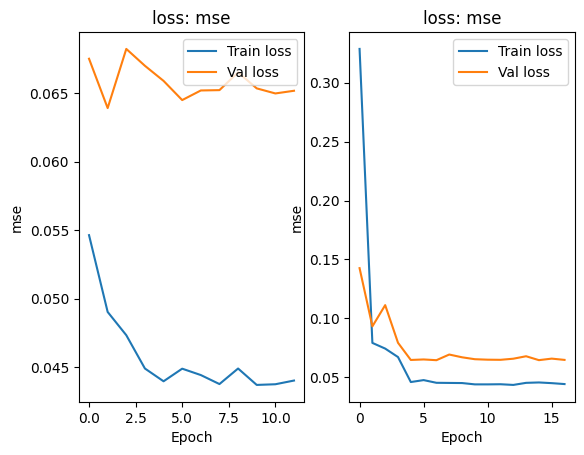

In [29]:
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


## Test

In [30]:
# predictions
y_pred = model_best.predict(X_test)

# Inverse transform the normalized predictions and actual values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

1/1 [==============================] - 0s 312ms/step


In [31]:
X_test.shape

(15, 12, 64800)

In [32]:
y_pred.shape

(15, 64800)

In [33]:
y_test.shape

(15, 64800)

R^2 Score: -0.11708792892086632


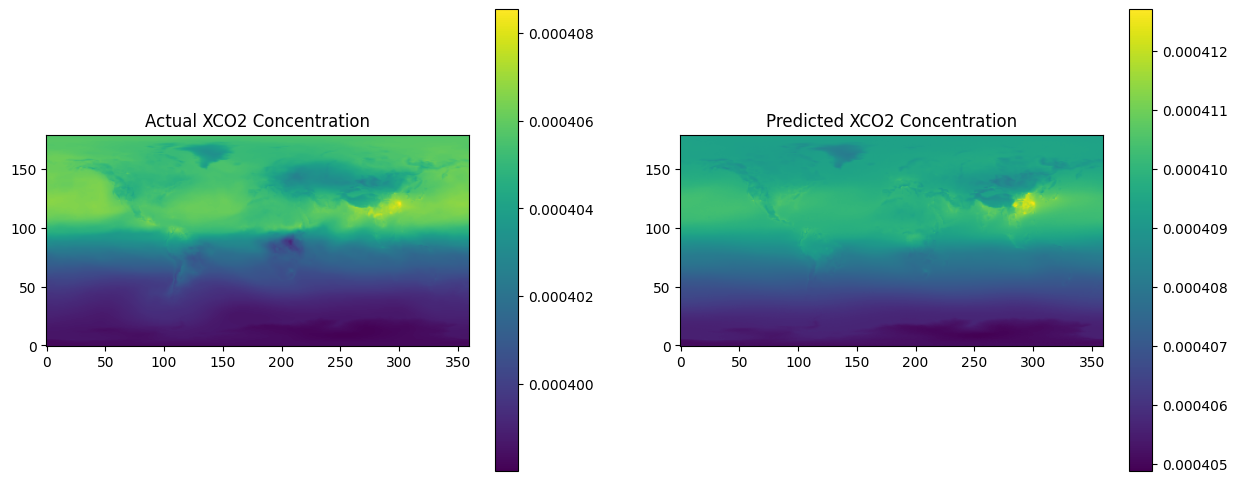

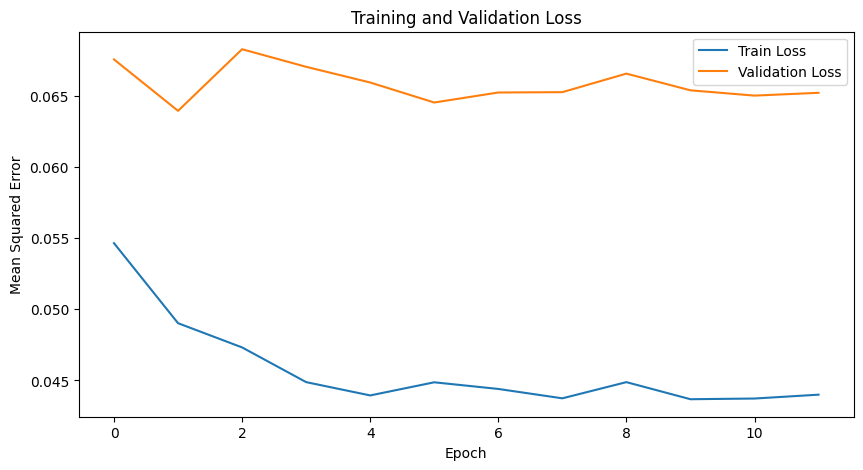

In [38]:
# Evaluate R^2 score
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f'R^2 Score: {r2}')

# Plotting actual vs predicted maps
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_test_inverse[0, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Actual XCO2 Concentration')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_inverse[0, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Predicted XCO2 Concentration')
plt.colorbar()

plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()

## Long dataset (2005.01 ~ 2022.02)

In [43]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [44]:
co2_data = nc.Dataset('organized_data_final_0501_2202__incCO2.nc')

In [45]:
co2 = co2_data.variables['co2_data'][:]
#n2o = all_data.variables['n2o_data'][:]
temp = co2_data.variables['temp_data'][:]
year_month = co2_data.variables['year_month'][:]

In [46]:
co2.shape

(206, 180, 360)

In [51]:
# Reshape XCO2 data for LSTM input
co2_reshaped = co2.reshape((206, -1))

# Normalize data
scaler = MinMaxScaler()
co2_normalized = scaler.fit_transform(co2_reshaped)

# Prepare input and target sequences for LSTM
sequence_length = 12


In [52]:
X, y = [], []
for i in range(206 - sequence_length):
    X.append(co2_normalized[i:i+sequence_length, :])
    y.append(co2_normalized[i+sequence_length, :])

X, y = np.array(X), np.array(y)


In [53]:
X.shape

(194, 12, 64800)

In [56]:
# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# same model as the one with above (manual model)
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(X_train.shape[2]))

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(155, 12, 64800)
(39, 12, 64800)
(155, 64800)
(39, 64800)


In [58]:
custom_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=custom_optimizer, loss='mse')

In [59]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=2)

# predictions
y_pred = model.predict(X_test)

# Inverse transform the normalized predictions and actual values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

Epoch 1/100
10/10 - 5s - loss: 0.3223 - val_loss: 0.2959 - 5s/epoch - 478ms/step
Epoch 2/100
10/10 - 1s - loss: 0.2579 - val_loss: 0.2098 - 729ms/epoch - 73ms/step
Epoch 3/100
10/10 - 1s - loss: 0.1684 - val_loss: 0.1206 - 729ms/epoch - 73ms/step
Epoch 4/100
10/10 - 1s - loss: 0.0979 - val_loss: 0.0696 - 753ms/epoch - 75ms/step
Epoch 5/100
10/10 - 1s - loss: 0.0691 - val_loss: 0.0593 - 739ms/epoch - 74ms/step
Epoch 6/100
10/10 - 1s - loss: 0.0667 - val_loss: 0.0549 - 776ms/epoch - 78ms/step
Epoch 7/100
10/10 - 1s - loss: 0.0586 - val_loss: 0.0836 - 766ms/epoch - 77ms/step
Epoch 8/100
10/10 - 1s - loss: 0.0490 - val_loss: 0.0327 - 748ms/epoch - 75ms/step
Epoch 9/100
10/10 - 1s - loss: 0.0409 - val_loss: 0.0234 - 739ms/epoch - 74ms/step
Epoch 10/100
10/10 - 1s - loss: 0.0236 - val_loss: 0.0171 - 749ms/epoch - 75ms/step
Epoch 11/100
10/10 - 1s - loss: 0.0213 - val_loss: 0.0132 - 748ms/epoch - 75ms/step
Epoch 12/100
10/10 - 1s - loss: 0.0120 - val_loss: 0.0055 - 724ms/epoch - 72ms/step
Epo

In [62]:
y_pred_inverse.shape

(39, 64800)

R^2 Score: 0.9362744103337938


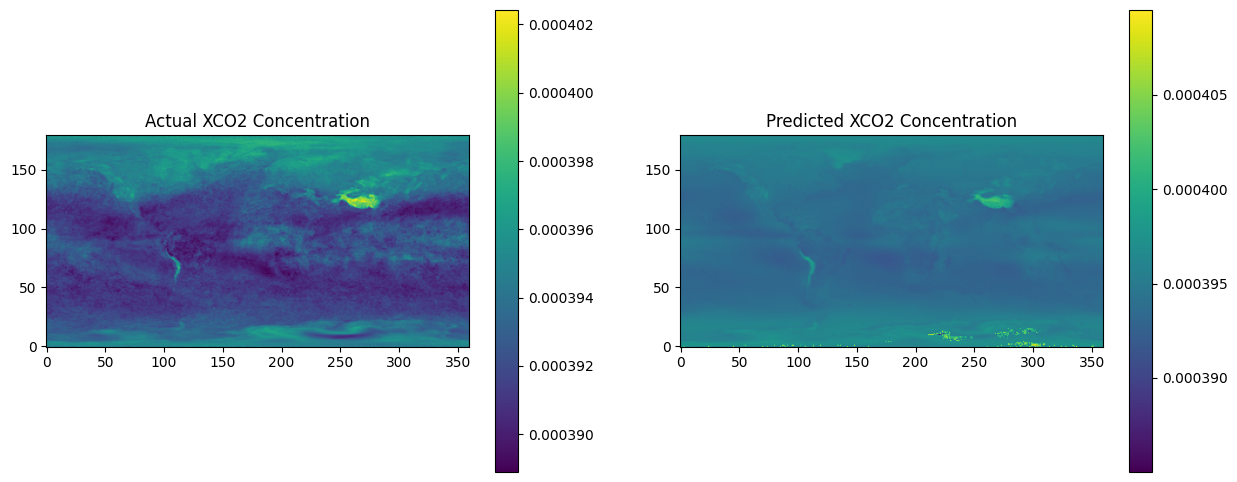

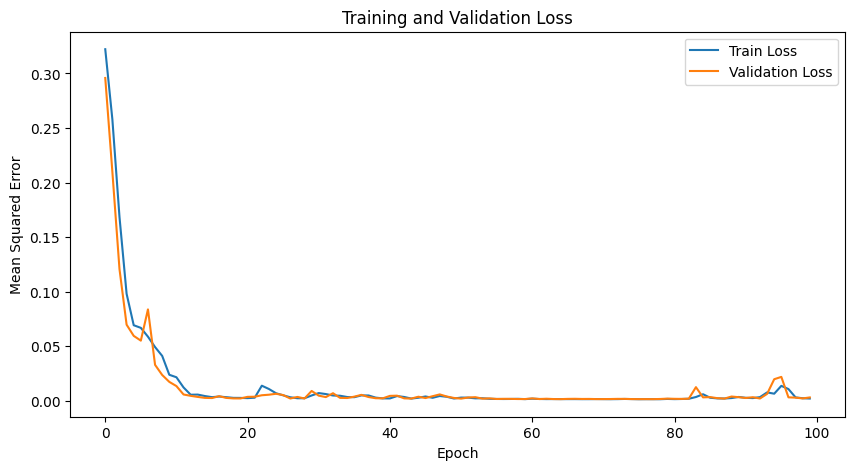

In [63]:
# Evaluate R^2 score
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f'R^2 Score: {r2}')

# Plotting actual vs predicted maps
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_test_inverse[38, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Actual XCO2 Concentration')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_inverse[38, :].reshape(co2.shape[1:]), cmap='viridis', origin='lower')
plt.title('Predicted XCO2 Concentration')
plt.colorbar()

plt.show()

# Plotting training and validation loss
plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()